# Introduction to Time Series Algorithm

Time series data is an important source for information and strategy used in various businesses. From a conventional finance industry to education industry, they play a major role in understanding a lot of details on specific factors with respect to time. Time series forecasting is basically the machine learning modeling for Time Series data (years, days, hours…etc.)for predicting future values using Time Series modeling .This helps if your data in serially correlated.

We will be using the AirPassenger dataset for our Time Series Forecasting

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (16, 6)

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/anup-jana/Python-Machine-Learning/master/Datasets/international-airline-passengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121

 Data Types:
Month         object
Passengers     int64
dtype: object


The data contains a particular month and number of passengers (in thousands) travelling in that month. You can observe that  data type for "Month" feature is object. Let’s convert it into a Time series object and use the Month column as our index.

In [3]:
from datetime import datetime

con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

data.index # check datatype of index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

You can see that now the data type is ‘datetime64[ns]’. Now let’s just make it into a series rather than a data frame and then Let’s explore the various properties date-time based index:

In [4]:
# Convert to time series:
ts = data['Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: Passengers, dtype: int64

In [5]:
# Specific index as a string constant:
print('index as constant: ', ts['1949-01-01'])
print('index as datetime: ', ts[datetime(1949,1,1)])

index as constant:  112
index as datetime:  112


In [6]:
# Specify entire range
ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: Passengers, dtype: int64

In [7]:
# Specify end index
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: Passengers, dtype: int64

In [8]:
# All rows of 1949 year
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: Passengers, dtype: int64

### STATIONARITY
This is a very important concept in Time Series Analysis. In order to apply a time series model, it is important for the Time series to be stationary; in other words all its statistical properties (mean,variance) remain constant over time. This is done basically because if you take a certain behavior over time, it is important that this behavior is same in the future in order for us to forecast the series.

In practice we can assume the series to be stationary if it has constant statistical properties over time and these properties can be: constant mean, constant variance, an auto co-variance that does not depend on time.

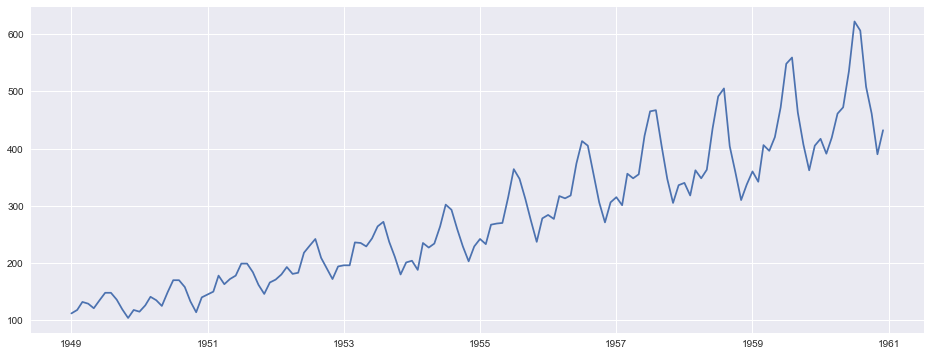

In [9]:
plt.plot(ts);

The best way to understand you stationarity in a Time Series is by eye-balling the plot. You can notice above from the plot that there is an overall increase in the trend, with some seasonality in it. Let's plot the moving mean or moving Standard Deviation i.e. At any instant ‘t’, we take the mean/std of the last year which in this case is 12 months)

Dickey-fuller Test: This is one of the statistical tests for checking stationarity. First we consider the null hypothesis: the time series is non- stationary. The result from the rest will contain the test statistic and critical value for different confidence levels. The idea is to have Test statistics less than critical value, in this case we can reject the null hypothesis and say that this Time series is indeed stationary

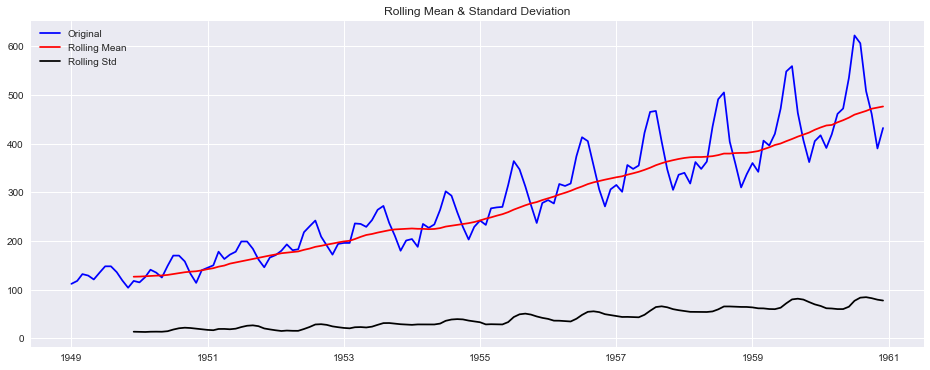

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
# Lags Used                     13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)

This is not stationary because : (1) mean is increasing even though the std is small, (2) Test stat is > critical value (3)• Note: the signed values are compared and the absolute values.

### MAKING THE TIME SERIES STATIONARY
There are two major factors that make a time series non-stationary. They are: (1) Trend: non-constant mean, (2) Seasonality: Variation at specific time-frames.

The basic idea is to model the trend and seasonality in this series, so we can remove it and make the series stationary. Then we can go ahead and apply statistical forecasting to the stationary series. And finally we can convert the forecasted values into original by applying the trend and seasonality constrains back to those that we previously separated.

Let’s start by working on the trend piece.

#### Trend
The first step is to reduce the trend using transformation, as we can see here that there is a strong positive trend. These transformation can be log, sq-rt, cube root etc . Basically it penalizes larger values more than the smaller. In this case we will use the logarithmic transformation.

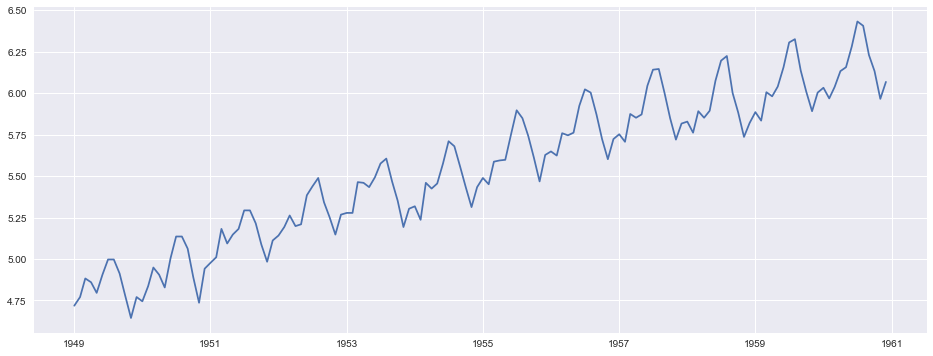

In [11]:
ts_log = np.log(ts)

plt.plot(ts_log);

There is some noise in realizing the forward trend here. There are some methods to model these trends and then remove them from the series. Some of the common ones are: (1) Smoothing: using rolling/moving average and (2) Aggression: by taking the mean for a certain time period (year/month)

Let's use Smoothing technique. In smoothing we usually take the past few instances (rolling estimates) We will discuss two methods under smoothing- Moving average and Exponentially weighted moving average. Moving average - First take x consecutive values and this depends on the frequency if it is 1 year we take 12 values. Lucky for us that Pandas has a function for rolling estimate.

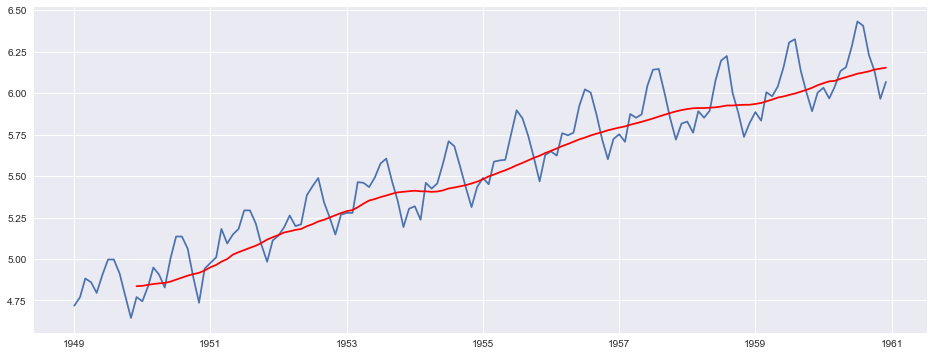

In [12]:
moving_avg = pd.rolling_mean(ts_log, 12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red');

Now subtract the rolling mean from the original series. The reason there are null values is because we take the average of first 12 so 11 values are null. We can also see that in the visual representation of moving average plot above. Thus it is dropped for further analysis. Now let’s parse it to the function to check for stationarity.

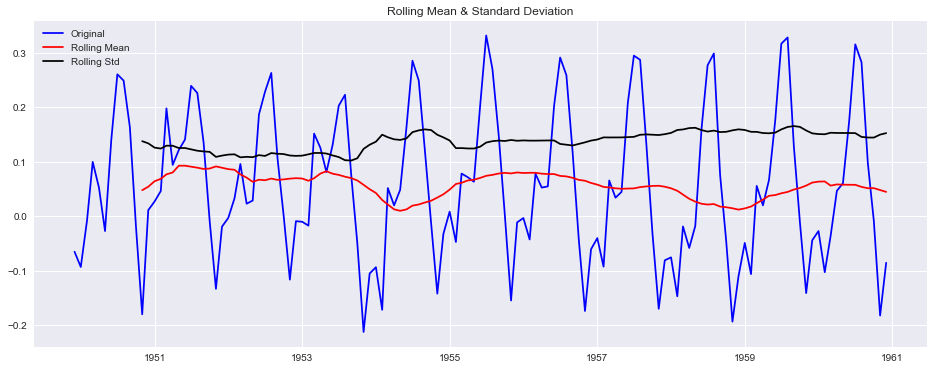

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
# Lags Used                     13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [13]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

We notice two things: (1) The rolling values are varying slightly but there is no specific trend and (2) The test statistics is smaller than the 5 % critical values. That tells us that we are 95% confident that this series is stationary.

In this example we can easily take a time period (12 months for a year), but there are situations where the time period range is more complex like stock price etc. So we use the exponentially weighted moving average. The previous values are assigned with a decay factor. The parameter (halflife) is assumed 12, but it really depends on the domain. 

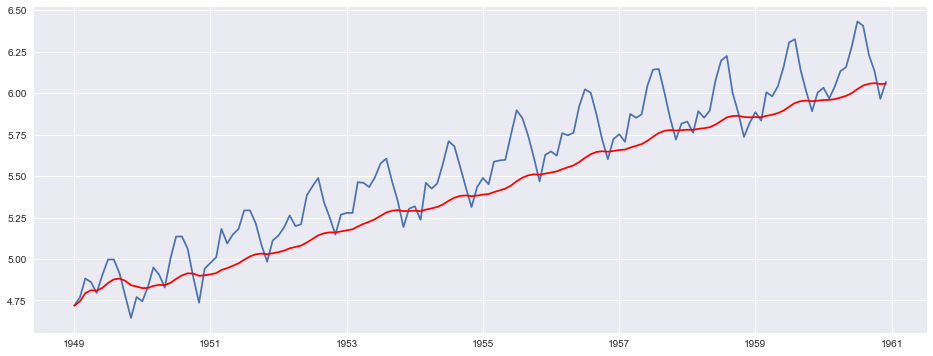

In [14]:
exp_weighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color='red');

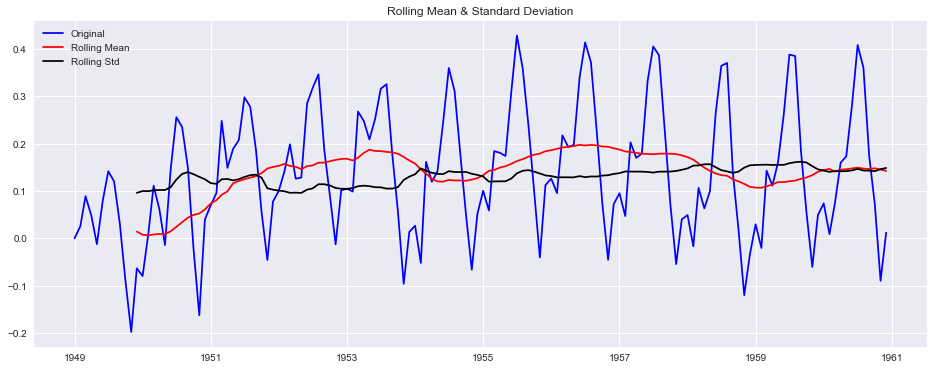

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
# Lags Used                     13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
# Let’s check stationarity now:
ts_log_ewma_diff = ts_log - exp_weighted_avg
test_stationarity(ts_log_ewma_diff)

It is stationary because: (1) Rolling values have less variations in mean and standard deviation in magnitude and (2) the test statistic is smaller than 1% of the critical value. So we can say we are almost 99% confident that this is stationary.

#### Seasonality (along with Trend)

Previously we saw just trend part of the time series, now we will see both trend and seasonality. Most Time series have trends along with seasonality. There are two common methods to remove trend and seasonality, they are: (1) Differencing: by taking difference using time lag and (2) Decomposition: model both trend and seasonality, then remove them

Differencing: Here we first take the difference of the value at a particular time with that of the previous time.

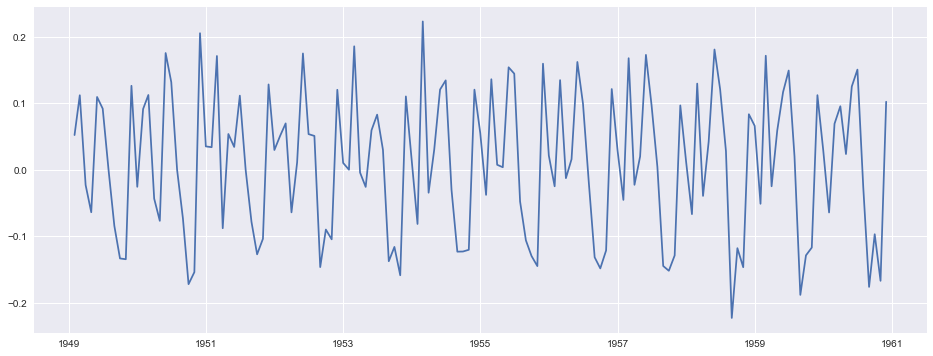

In [16]:
# take first difference
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff);

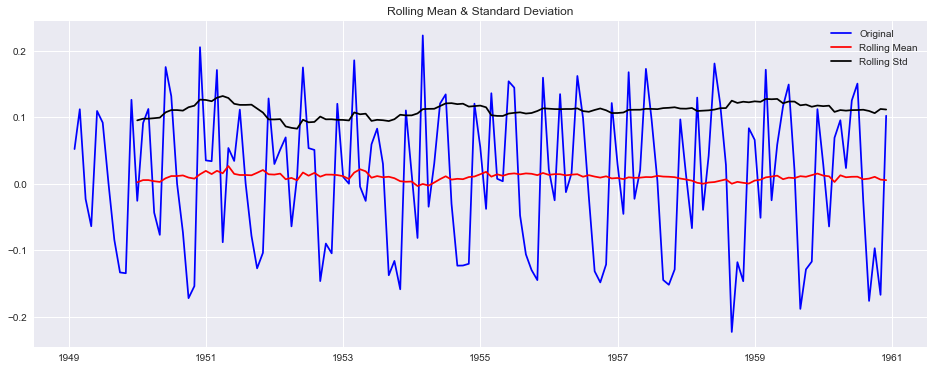

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
# Lags Used                     14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [17]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

It is stationary because: (1) the mean and std variations have small variations with time and (2) test statistic is less than 10% of the critical values, so we can be 90 % confident that this is stationary.

Decomposing: Here we model both the trend and the seasonality, then the remaining part of the time series is returned.

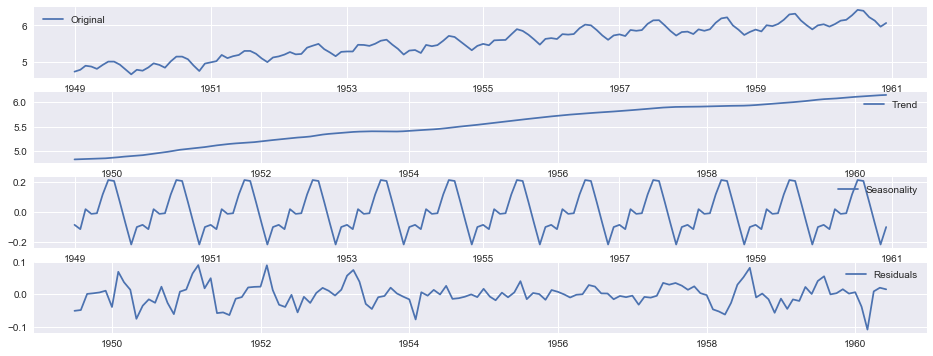

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best');

Remove the trend and seasonality from the Time series and now we can use the residual values. Let’s check stationarity.

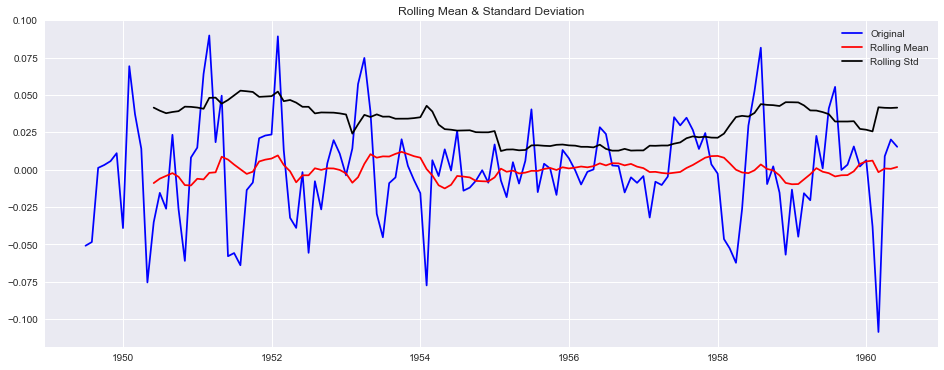

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
# Lags Used                    9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [19]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

This is stationary because: (1) test statistic is lower than 1% critical values and (2) the mean and std variations have small variations with time.

### Forecasting a Time Series

Now that we have made the Time series stationary, let’s make models on the time series using differencing because it is easy to add the error , trend and seasonality back into predicted values. We will use statistical modelling method called ARIMA to forecast the data where there are dependencies in the values.

Auto Regressive Integrated Moving Average(ARIMA) — It is like a liner regression equation where the predictors depend on parameters (p,d,q) of the ARIMA model .

• p : This is the number of AR (Auto-Regressive) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3).

• q : This is the number of MA (Moving-Average) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3).

• d :This is the number of differences or the number of non-seasonal differences.

Now let’s check out on how we can figure out what value of p and q to use. We use two popular plotting techniques; they are:

• Autocorrelation Function (ACF): It just measures the correlation between two consecutive (lagged version). example at lag 4, ACF will compare series at time instance t1…t2 with series at instance t1–4…t2–4

• Partial Autocorrelation Function (PACF): is used to measure the degree of association between y(t) and y(t-p).

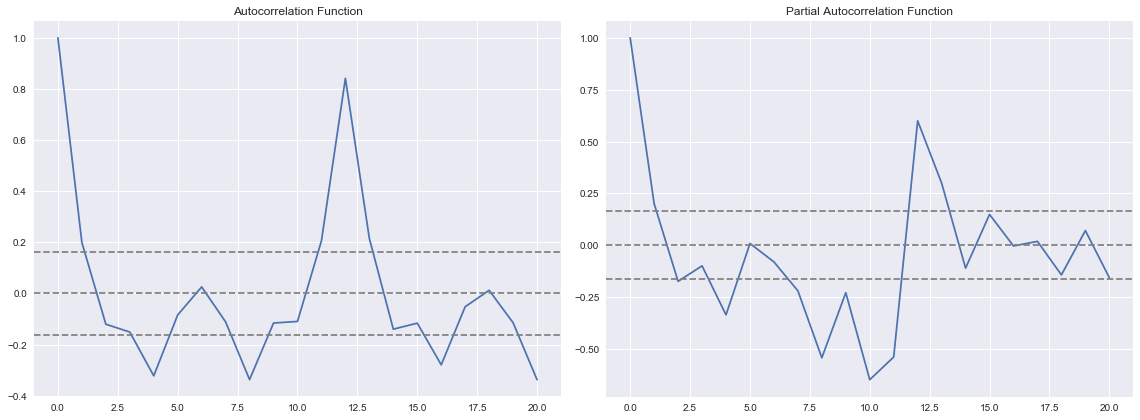

In [20]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

# Plot ACF
plt.subplot(1,2,1)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(1,2,2)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout();

The two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values as:

• p: The first time where the PACF crosses the upper confidence interval, here its close to 2. hence p = 2.

• q: The first time where the ACF crosses the upper confidence interval, here its close to 2. hence q = 2.

Now, using this make 3 different ARIMA models considering individual as well as combined effects. We will also calculate the Residual Sum Of Squares (RSS)

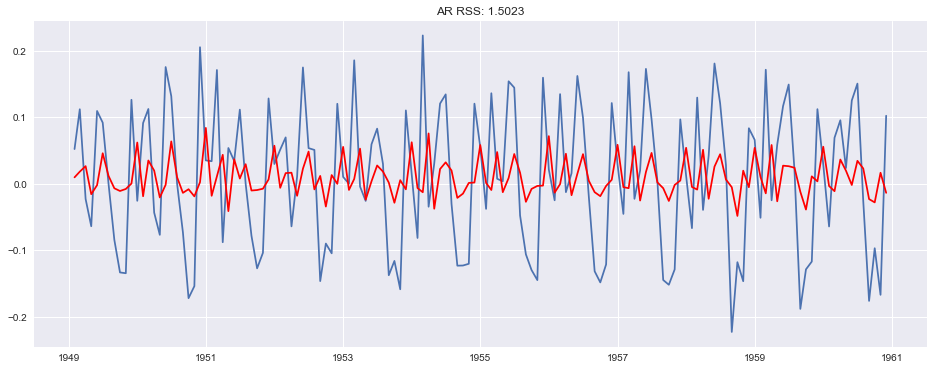

In [21]:
# AR Model
model = ARIMA(ts_log, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('AR RSS: %.4f' % sum((results_AR.fittedvalues-ts_log_diff)**2));

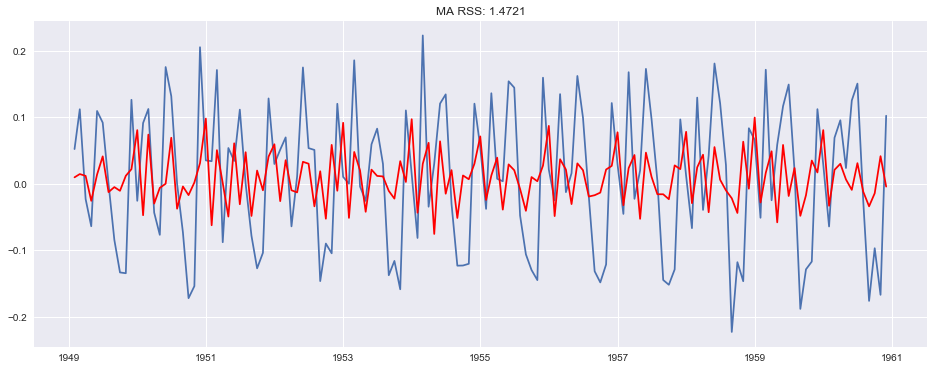

In [22]:
# MA Model

model = ARIMA(ts_log, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA RSS: %.4f' % sum((results_MA.fittedvalues-ts_log_diff)**2));

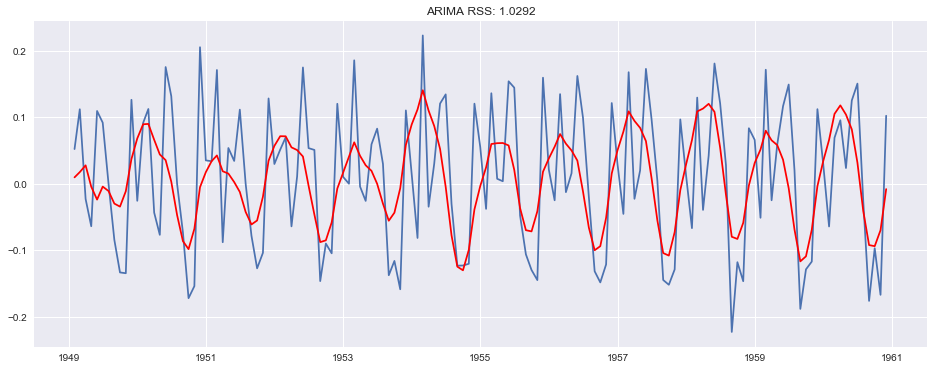

In [23]:
# ARIMA Model

model = ARIMA(ts_log, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA RSS: %.4f' % sum((results_ARIMA.fittedvalues-ts_log_diff)**2));

RSS values: (1) AR=1.5023 (2) MA=1.472 (3) ARIMA=1.0292 So, ARIMA has the best RSS values.

#### FINAL STEP: BRINGING THIS BACK TO THE ORIGINAL SCALE
First get the predicted values and store it as series. You will notice the first month is missing because we took a lag of 1(shift). Now convert differencing to log scale: find the cumulative sum and add it to a new series with a base value (here the first-month value of the log series).

In [24]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print('Predicted ARIMA Difference: \n',predictions_ARIMA_diff.head())
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print('\nPredicted ARIMA Difference CUMSUM: \n',predictions_ARIMA_diff_cumsum.head())
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print('\nPredicted ARIMA Log: \n',predictions_ARIMA_log.head())

Predicted ARIMA Difference: 
 Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

Predicted ARIMA Difference CUMSUM: 
 Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

Predicted ARIMA Log: 
 Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64


Next, take the exponent of the series from above (anti-log) which will be the predicted value — the time series forecast model. Now, plot the predicted values with the original and then let's Find the RMSE

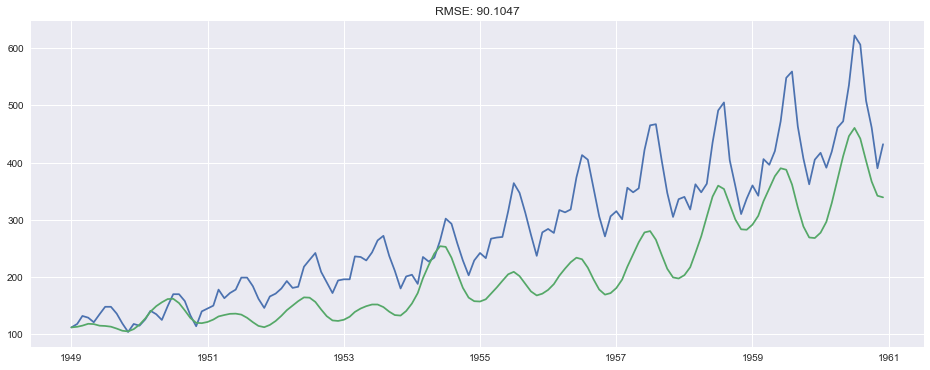

In [25]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f' % np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)));

The result can be further refined to get a better model. Enjoy refining the model and achieve better model!